In [1]:
from Truss_2D import Truss_2D
import numpy as np
from random import random
import matplotlib.pyplot as plt 

### Step 1: Define Model Analysis

In [2]:
def Truss_solver(cross_sectional_areas):
    nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
    elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
    supports = {5:[1,1], 6:[1,1]}
    forces = {2:[0,-100], 4:[0,-100]}
    elasticity = {key: 10_000 for key in elements}
    cross_area = {1:cross_sectional_areas[0], 2:cross_sectional_areas[1], 3:cross_sectional_areas[2], 4:cross_sectional_areas[3], 5:cross_sectional_areas[4],
                  6:cross_sectional_areas[5], 7:cross_sectional_areas[6], 8:cross_sectional_areas[7], 9:cross_sectional_areas[8], 10:cross_sectional_areas[9]}

    Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                    elements= elements,
                                    supports= supports,
                                    forces = forces,
                                    elasticity= elasticity,
                                    cross_area= cross_area)

    Ten_Bar_Truss_Case_1.Solve()

    return (Ten_Bar_Truss_Case_1.member_lengths_, Ten_Bar_Truss_Case_1.member_stresses_, Ten_Bar_Truss_Case_1.displacements_)

#### Step 2: Define Objective Function

In [3]:
def Objective_Function(areas):
    
    member_lengths, member_stresses, node_displacements = Truss_solver(areas)    
    total_area = np.array(areas)
    total_member_lengths = []
    
    for length in member_lengths:
        total_member_lengths.append(member_lengths[length])

    total_member_lengths = np.array(total_member_lengths)

    weight = total_area.dot(np.array(total_member_lengths))

    weight = weight.sum() * 0.1 # lb/in^3

    return (weight, member_stresses, node_displacements)

#### Step 3: Define Constraints

In [4]:
def stress_constraint(stresses_new):
    stress_counter = []
    
    for stress in range(1,len(stresses_new)+1):
        if stresses_new[stress] >= 25 or stresses_new[stress] <= -25:
            stress_counter.append(1)
        else:
            stress_counter.append(0)
    
    return sum(stress_counter)

In [5]:
def displacement_constraint(node_displacement_new):
    displacement_counter = []
    
    for displacement in range(1,len(node_displacement_new)+1):
        x = node_displacement_new[displacement][0]
        y = node_displacement_new[displacement][1]
        if x >= 2 or x <= -2:
            displacement_counter.append(1)
        elif y >= 2 or y <= -2:
            displacement_counter.append(1)
        else:
            displacement_counter.append(0)

    return sum(displacement_counter)

### Step 4: Define Algorithm

Step 4.1: Initialize Parameters

In [6]:
# Initialize Wolves
alpha_position = 50
alpha_score = float("inf")

beta_position = 10
beta_score = float("inf")

delta_position = 25
delta_score = float("inf")

# Initialize No. of Wolves (Search Agents)
search_agents = 15

# Total Number of Iterations
max_iterations = 30

# Upper and Lower Boundary values for the wolves' location
ub = 50
lb = 10

# Initialize Random Location of No. of Wolves (Search Agents)
positions = np.zeros(search_agents)
for i in range(search_agents):
    positions[i] = np.random.uniform(0,1) * (ub - lb) + lb

In [7]:
best_alpha_score = []
best_alpha_positions = []
best_beta_positions = []
best_delta_positions = []

### Step 4.2: Grey Wolf Algorithm

In [8]:
%%time

for m in range(0, max_iterations):
    for i in range(0, search_agents):

        # Return back the search agents that go beyond the boundaries of the search space
        for j in range(search_agents):
            positions[j]=np.clip(positions[j], lb, ub)

        # Calculate objective function for each search agent
        fitness, stresses_new, node_displacement_new = Objective_Function([positions[i] for k in range(10)])

        # Contraint 1: stresses should be within 25ksi and -25ksi
        stress_counter = stress_constraint(stresses_new)

        # Constraint 2: Node Displacement should be limited to -2in and 2in
        displacement_counter = displacement_constraint(node_displacement_new)

        # if counters are greater than 1 (constraint violated), dont do anything. Otherwise continue with GWO
        if (stress_counter >= 1 or displacement_counter >= 1):
            pass
        else:
            if fitness < alpha_score:
                alpha_score = fitness
                alpha_position = positions[i].copy()
            if (fitness > alpha_score and fitness < beta_score):
                beta_score = fitness
                beta_position = positions[i].copy()
            if (fitness > alpha_score and fitness > beta_score and fitness < delta_score):
                delta_score = fitness
                delta_position = positions[i].copy()

    a = 2 - m*(2/max_iterations)

    for i in range(0,search_agents):
        # compute distance of alpha
        r1 = random()
        r2 = random()

        a1 = 2*a*r1-a
        c1 = 2*r2

        distance_alpha = abs(c1*alpha_position-positions[i])
        x1 = alpha_position - a1*distance_alpha

        # compute distance of beta        
        r1 = random()
        r2 = random()

        a2 = 2*a*r1-a
        c2 = 2*r2

        distance_beta = abs(c2*beta_position-positions[i])
        x2 = beta_position - a2*distance_beta

        # compute distance of delta        
        r1 = random()
        r2 = random()

        a3 = 2*a*r1-a
        c3 = 2*r2

        distance_delta = abs(c3*delta_position-positions[i])
        x3 = delta_position - a3*distance_delta

        # in the middle (average) of the 3 wolf's distance (encircle), the prey is found
        positions[i] = (x1 + x2 + x3) / 3

    best_alpha_score.append(alpha_score)
    best_alpha_positions.append(alpha_position)
    best_beta_positions.append(beta_position)
    best_delta_positions.append(delta_position)

Wall time: 701 ms


## Plots and Results

### Convergence Graph

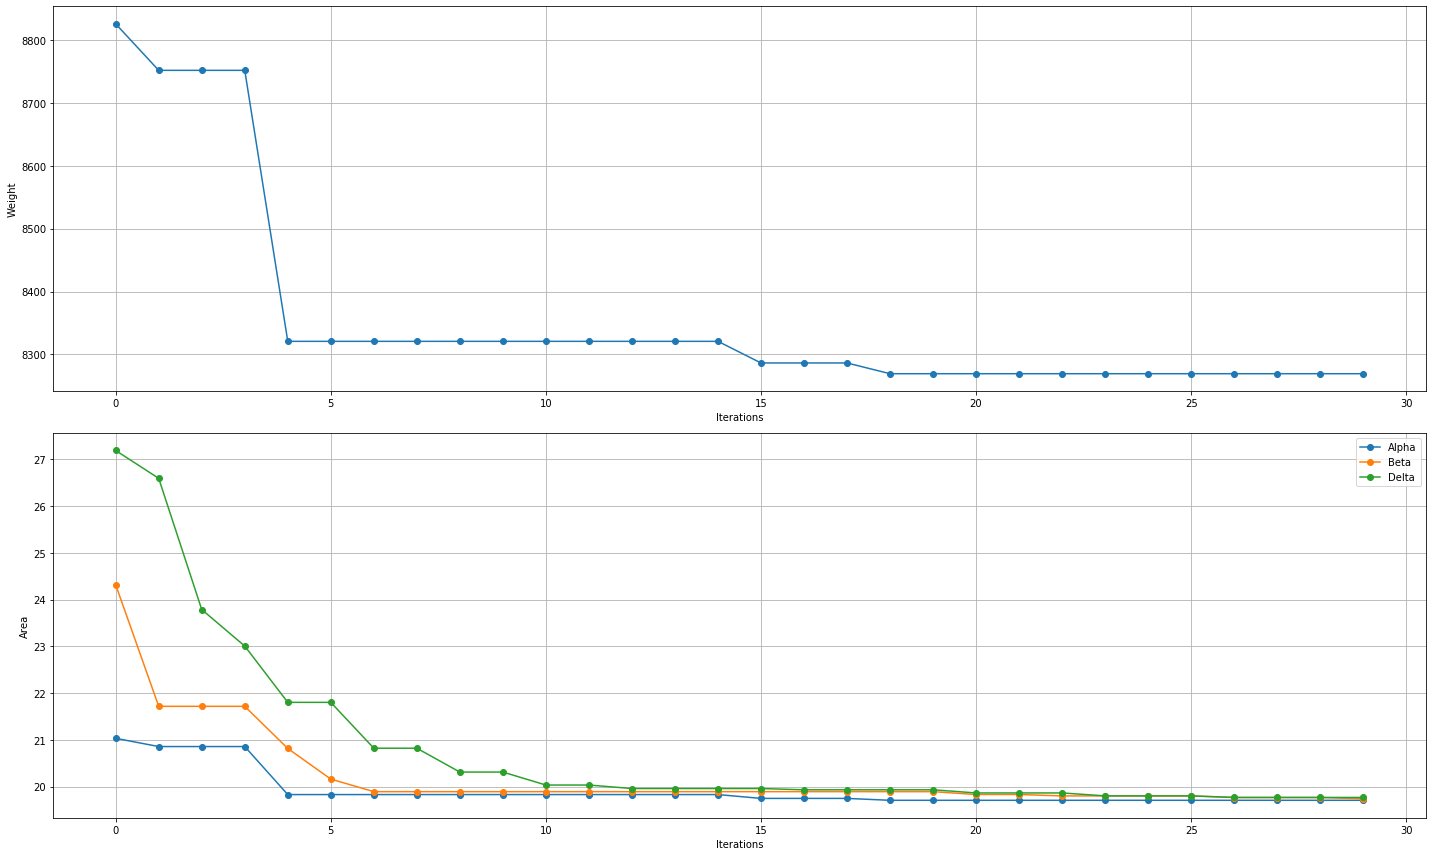

In [9]:
fig, axs = plt.subplots(2,1)
fig.set_figheight(12)
fig.set_figwidth(20)
axs[0].plot(best_alpha_score, marker = 'o')
axs[0].grid(True)
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Weight')

axs[1].plot(best_alpha_positions, label = 'Alpha', marker = 'o')
axs[1].plot(best_beta_positions, label = 'Beta', marker = 'o')
axs[1].plot(best_delta_positions, label = 'Delta', marker = 'o')
axs[1].grid(True)
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Area')
axs[1].legend()

fig.tight_layout()

## Check Solution of Optimization

In [10]:
nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
supports = {5:[1,1], 6:[1,1]}
forces = {2:[0,-100], 4:[0,-100]}
elasticity = {key: 10_000 for key in elements}
cross_area = {key: positions[-1] for key in range(1,11)}

Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                elements= elements,
                                supports= supports,
                                forces = forces,
                                elasticity= elasticity,
                                cross_area= cross_area)

Ten_Bar_Truss_Case_1.Solve()

In [11]:
Ten_Bar_Truss_Case_1.displacements_

{1: [0.42266, -1.89208],
 2: [-0.47474, -1.96409],
 3: [0.35064, -0.83476],
 4: [-0.36728, -0.89845],
 5: [0.0, 0.0],
 6: [0.0, 0.0]}

In [12]:
Ten_Bar_Truss_Case_1.member_stresses_

{1: 9.74,
 2: 2.00056,
 3: -10.20222,
 4: -2.985,
 5: 1.76917,
 6: 2.00028,
 7: 7.37736,
 8: -6.72389,
 9: 4.22153,
 10: -2.82903}

In [13]:
weight, _, _ = Objective_Function([positions[-1] for i in range(10)])
weight

8417.268881538475